In [3]:
from utils import *

In [4]:
base_model_name = "paraphrase-multilingual-mpnet-base-v2" 
fine_tunned_model_path = "./Data/fine-tuned-bert-2022-02-19-13-54-50"
import_path = "./Data/Relevant vs Irrelevant.csv"
data_embeddings_dir = "./Data/"

# Data Import 

In [5]:
df = pd.read_csv(import_path)

In [6]:
df.head(5)

,_id,target,lemma_maintext,lemma_title,lemma_description,description,language,maintext,title,url
0,rfZFWnoByGgeg43IrgIr,1,"['rapport', 'fournir', 'recherche', 'précis', ...","['taille', 'ingrédient', 'alimentaire', 'fonct...","['rapport', 'recherche', 'ingrédient', 'alimen...",Notre rapport de recherche « Ingrédient Alime...,fr,"Le rapport fournit des recherches précises, de...",Taille du Ingrédient Alimentaire Fonctionnel m...,https://millaujournal.com/2021/06/30/taille-du...
1,dQYh1HkBTz7BZCTC2Cmh,0,"['local', 'school', 'board', 'state', 'supreme...","['microsoft', 'want', 'voting', 'trustworthy',...","['late', 'february', 'microsoft', 'carry', 'of...","In late February 2020, Microsoft carried out ...",en,the local school board and a state supreme cou...,Microsoft wants to make voting more trustworth...,https://www.msn.com/en-us/news/politics/micros...
2,EAYK1HkBTz7BZCTCIiBw,1,"['e', 'oportunidade', 'crescimento', 'mercar',...","['tamanho', 'dispositivos', 'cardiologia', 'in...","['o', 'relatório', 'global', 'dispositivos', '...",O relatório Global Dispositivos de cardiologi...,pt,e oportunidades de crescimento do mercado Disp...,Tamanho Dispositivos de cardiologia intervenci...,https://actualpenacov.com/2021/06/04/tamanho-d...
3,lwV30nkBTz7BZCTCSAr_,1,"['process', 'instrumentation', 'market', 'expe...","['insight', 'process', 'instrumentation', 'glo...","['process', 'instrumentation', 'market', 'grow...","The ""Process Instrumentation Market - Growth,...",en,The process instrumentation market is expected...,Insights on the Process Instrumentation Global...,https://www.benzinga.com/pressreleases/21/06/b...
4,LAWH0nkBTz7BZCTCXhV7,1,"['technologique', 'part', 'taille', 'prévision...","['analyse', 'récupération', 'impact', 'coronav...","['analyse', 'récupération', 'impact', 'coronav...",Analyse de la récupération de l'impact des co...,fr,"technologique, part, taille et prévisions NXP,...",Analyse de la récupération de l'impact des cor...,https://journallactionregionale.com/2021/06/03...


## Dependent variable frequencies

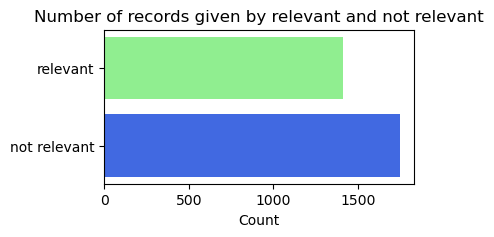

Number of relevant texts is 1411
Number of not not relevant texts is 1748


In [7]:
plt.rcdefaults()
fig, ax = plt.subplots()
fig.set_size_inches(4, 2)

# Example data
example = ["relevant","not relevant"]
y_pos = np.arange(2)
performance = [df.loc[df['target'] == 1].count()[0],df.loc[df['target'] == 0].count()[0]]            
error = np.random.rand(2)
colors = ['lightgreen', 'royalblue'] # set the colors

ax.barh(y_pos, performance,  align='center', color = colors) # xerr=error
ax.set_yticks(y_pos)
ax.set_yticklabels(example)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Count')
ax.set_title('Number of records given by relevant and not relevant')

plt.show()
fig.savefig("./Data/counts.jpg",bbox_inches='tight')

# Print number of funny and number of serious texts
print("Number of relevant texts is " + str(df.loc[df['target'] == 1].count()[0]))
print("Number of not not relevant texts is " + str(df.loc[df['target'] == 0].count()[0]))

# Preprocessing

In [ ]:
sentences_lst = df["maintext"].tolist()

In [ ]:
embeddings = embeddings_sentence_bert(sentences_lst, True, base_model_name)

In [19]:
embeddings_tunned = embeddings_sentence_bert(sentences_lst, False, fine_tunned_model_path)


Time for creating 3159 embedding vectors 100.2126537958781
Model used :./Data/fine-tuned-bert-2022-02-19-13-54-50


In [20]:
data = pd.DataFrame([[i] for i in tqdm(embeddings)]).rename(columns={0:'maintext_embed'})
data_tunned = pd.DataFrame([[i] for i in tqdm(embeddings_tunned)]).rename(columns={0:'maintext_embed'})

In [21]:
data_concat = pd.concat([df.reset_index(), data.reset_index()], axis=1)
data_concat_tunned = pd.concat([df.reset_index(), data_tunned.reset_index()], axis=1)

In [22]:
# save data with embeddings 
data_concat.to_pickle(data_embeddings_dir + "embeddings.pickle")
data_concat_tunned.to_pickle(data_embeddings_dir + "embeddings_tunned.pickle")

In [23]:
data_concat = data_concat_tunned

# Baseline BERT contextual representation

In [8]:
result, matrix, report, precision, recall, auc_score = train_evaluate_model(data_embeddings_dir + "embeddings.pickle")

Training starts...
Time for training and grid search optimization: 1.5520753542582193
Model accuracy on train set is 0.984622342831298
Model accuracy on test set is 0.9767932489451476


In [9]:
result

[{'grid': GridSearchCV(cv=5, estimator=Pipeline(steps=[('clf', LogisticRegression())]),
               param_grid={'clf__penalty': ['l2', 'l1']}),
  'classifier': Pipeline(steps=[('clf', LogisticRegression())]),
  'best score': 0.9701510678937316,
  'best params': {'clf__penalty': 'l2'},
  'cv': 5},
 {'grid': GridSearchCV(cv=5, estimator=Pipeline(steps=[('clf', SVC())]),
               param_grid={'clf__class_weight': ['balanced'],
                           'clf__kernel': ['linear', 'poly', 'sigmoid'],
                           'clf__probability': [True]}),
  'classifier': Pipeline(steps=[('clf',
                   SVC(class_weight='balanced', kernel='poly',
                       probability=True))]),
  'best score': 0.9687895161537441,
  'best params': {'clf__class_weight': 'balanced',
   'clf__kernel': 'poly',
   'clf__probability': True},
  'cv': 5},
 {'grid': GridSearchCV(cv=5,
               estimator=Pipeline(steps=[('clf', RandomForestClassifier())]),
               param_gri

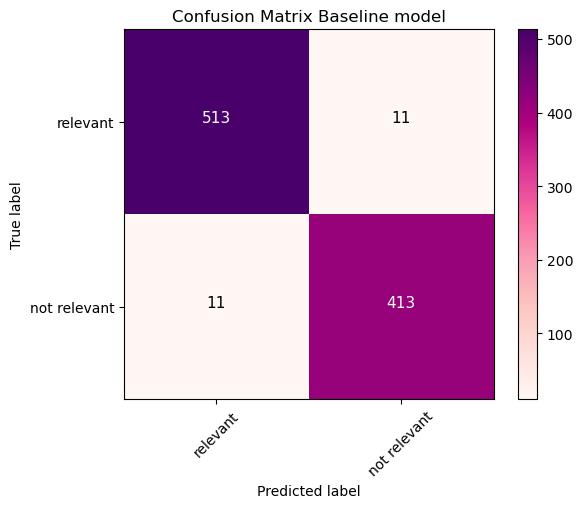

In [10]:
plot_confusion_matrix(matrix , title = 'Confusion Matrix Baseline model')

In [11]:
print(report)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       524
           1       0.97      0.97      0.97       424

    accuracy                           0.98       948
   macro avg       0.98      0.98      0.98       948
weighted avg       0.98      0.98      0.98       948



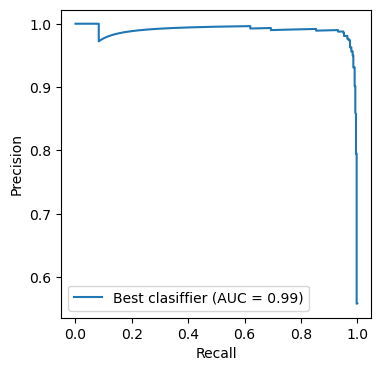

In [12]:
plot_P_R_curve(precision, recall, auc_score)

# Fine-tunned BERT contextual representation (see Bert fine-tunning.ipynb)

In [18]:
result, matrix, report, precision, recall, auc_score = train_evaluate_model(data_embeddings_dir + "embeddings_tunned.pickle")

Training starts...
Time for training and grid search optimization: 0.5594184835751851
Model accuracy on train set is 0.9990954319312528
Model accuracy on test set is 0.990506329113924


In [19]:
result

[{'grid': GridSearchCV(cv=5,
               estimator=Pipeline(steps=[('clf', RandomForestClassifier())]),
               param_grid={}),
  'classifier': Pipeline(steps=[('clf', RandomForestClassifier())]),
  'best score': 0.9900513773837369,
  'best params': {},
  'cv': 5},
 {'grid': GridSearchCV(cv=5, estimator=Pipeline(steps=[('clf', SVC())]),
               param_grid={'clf__class_weight': ['balanced'],
                           'clf__kernel': ['linear', 'poly', 'sigmoid'],
                           'clf__probability': [True]}),
  'classifier': Pipeline(steps=[('clf',
                   SVC(class_weight='balanced', kernel='linear',
                       probability=True))]),
  'best score': 0.9882414226326057,
  'best params': {'clf__class_weight': 'balanced',
   'clf__kernel': 'linear',
   'clf__probability': True},
  'cv': 5},
 {'grid': GridSearchCV(cv=5, estimator=Pipeline(steps=[('clf', LogisticRegression())]),
               param_grid={'clf__penalty': ['l2', 'l1']}),
  'cl

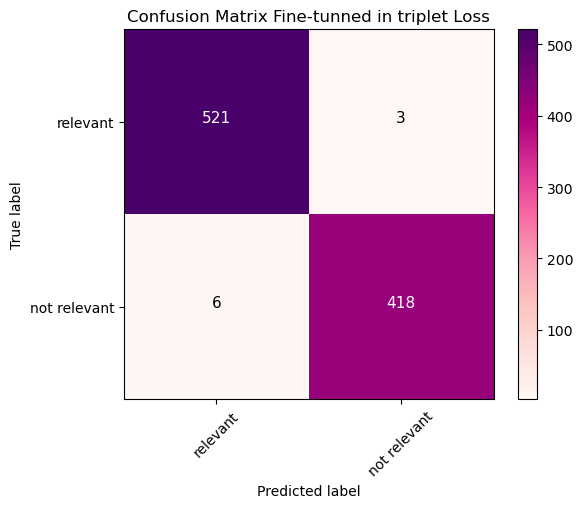

In [20]:
plot_confusion_matrix(matrix, title = 'Confusion Matrix Fine-tunned on triplet Loss')

In [21]:
print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       527
           1       0.99      0.99      0.99       421

    accuracy                           0.99       948
   macro avg       0.99      0.99      0.99       948
weighted avg       0.99      0.99      0.99       948



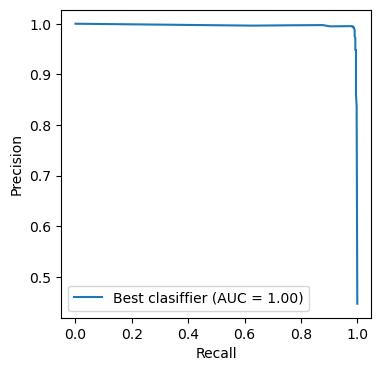

In [22]:
plot_P_R_curve(precision, recall, auc_score)